In [1]:
# We knew most of the solutions in the portfolio where its application of robust risk optimization.
#Hence, we dont need to use solver or corresponding functions in Scipy/ Numpy Library

In [1]:
import numpy as np
from numpy.linalg import det, inv, eigvals

import scipy
from scipy.optimize import minimize, LinearConstraint, Bounds

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mu_i = 0.1
sig_ii = 0.3
rho_ij = 0.25
n = 10

gamma = 1

In [3]:
mu = np.full(n, mu_i)
Sigma = np.full((n, n), rho_ij*sig_ii*sig_ii)

# Set the diagonal elements to the diagonal value
np.fill_diagonal(Sigma, sig_ii*sig_ii)


### Nominal Portfolio

In [4]:
def portfolio_performance(a, mu, Sigma, gamma):
    return -a.T @ mu + (gamma / 2) * a.T @ Sigma @ a

# Function to calculate worst-case covariance matrix
def worst_case_covariance_matrix(Sigma, theta, gamma, a):
    inv_Sigma_worst_case = inv(Sigma) - theta * gamma * np.outer(a, a)
    return inv(inv_Sigma_worst_case)

In [5]:
a_hat = (1/gamma)* inv(Sigma) @ mu

one = np.full(n, 1)
inv_Sigma = inv(Sigma)
lambd = (mu.T @ inv_Sigma @ one - gamma)/(one.T @ inv_Sigma @ one)
a_hat2 = (1/gamma)* inv_Sigma @ (mu - lambd* one)
a_hat

array([0.34188034, 0.34188034, 0.34188034, 0.34188034, 0.34188034,
       0.34188034, 0.34188034, 0.34188034, 0.34188034, 0.34188034])

In [6]:
performance_nominal = portfolio_performance(a_hat, mu, Sigma, gamma)
print("Performance in Nominal Model:", performance_nominal)

theta = 0.2
# Calculate worst-case covariance matrix
Sigma_worst_case = worst_case_covariance_matrix(Sigma, theta, gamma, a_hat)

# Calculate performance in the worst-case model
performance_worst_case = portfolio_performance(a_hat, mu, Sigma_worst_case, gamma)
print("Performance in Worst-Case Model:", performance_worst_case)

Performance in Nominal Model: -0.17094017094017097
Performance in Worst-Case Model: -0.15839410334823173


### Worst Case Portfolio

In [11]:
I = np.eye(n)

#speciific case for analysis
theta_ = 0.024792

def objective_a_oftheta(a, theta):
    term1 = 1 / np.sqrt(det(I - theta * gamma * np.outer(a,a) @ Sigma))
    return (1/theta)*np.log(term1) - a.T @ mu

def positive_definite_constraint(a, theta):
    eigenvalues = eigvals(inv(Sigma) - theta * gamma * np.outer(a,a) )
    return np.min(eigenvalues) - 1e-10  # Ensure all eigenvalues are slightly greater than zero


In [12]:
bounds = Bounds(0, np.inf)
# Initial guess for 'a'
a0 = np.ones(n)/n

# Define constraints in the format required by 'minimize'
constraints = {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)}

# Perform the optimization
result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))

# Check if the optimization was successful
if result.success:
    a_star = result.x
    print("Optimized a:", a_star)
    print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
else:
    print("Optimization failed:", result.message)

Optimized a: [0.33901361 0.33901361 0.33901278 0.3390142  0.3390142  0.3390148
 0.3390148  0.3390148  0.3390148  0.3390148 ]
 Minimum adjective reached at -0.1702237941541549 Not portfolio objective!


In [13]:
#computaion of entropy, risk_measurement
#mvo = mean variance objective
Sigma_tilda = inv(inv(Sigma) - theta_ * gamma * np.outer(a_star, a_star))

Rel_entropy = (np.log(det(Sigma @ inv(Sigma_tilda) )) + np.trace(inv(Sigma) @ Sigma_tilda - I))/2

RPs_nominal = portfolio_performance(a_star, mu, Sigma, gamma)
NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)

risk_meas2 = -np.dot(a_star, mu) + (gamma/2)*np.dot(a_star, np.dot(a_star, Sigma_tilda))
# Both of them are the same

In [14]:
print('RPs_nominal ', RPs_nominal)
print('NPs_worstcase ', NPs_worstcase)
print('RPs_worstcase ', RPs_worstcase)
print('Rel_entropy ', Rel_entropy)

RPs_nominal  -0.17092815717055818
NPs_worstcase  -0.16950351692556664
RPs_worstcase  -0.16951549013297484
Rel_entropy  1.756027329227229e-05


Scipy optimize based optimization

In [83]:
results_ = {}
thetas = (np.exp(np.linspace(0, 1)) - 1)[1:]
for theta_ in thetas:
    # Initial guess for 'a'
    a0 = np.ones(n)/n
    
    # Define constraints in the format required by 'minimize'
    constraints = {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)}
    
    # Perform the optimization
    result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))
    
    # Check if the optimization was successful
    if result.success:
        a_star = result.x
        print("Optimized a:", a_star)
        print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
    else:
        print("Optimization failed:", result.message)
    
    #computaion of entropy, risk_measurement
    #mvo = mean variance objective
    Sigma_tilda = inv(inv(Sigma) - theta_ * gamma * np.outer(a_star, a_star))
    
    Rel_entropy = (np.log(det(Sigma @ inv(Sigma_tilda) )) + np.trace(inv(Sigma) @ Sigma_tilda - I))/2
    
    RPs_nominal = portfolio_performance(a_star, mu, Sigma, gamma)
    NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
    RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)

    results_[theta_] = (Rel_entropy, NPs_worstcase, RPs_nominal, RPs_worstcase)

Optimized a: [0.33948848 0.33948848 0.3394892  0.33948848 0.33948848 0.33948848
 0.33948848 0.33948848 0.33948848 0.33948777]
 Minimum adjective reached at -0.1703432948611822 Not portfolio objective!
Optimized a: [0.33709313 0.33709313 0.33709313 0.33709313 0.33709277 0.33709242
 0.33709313 0.33709398 0.33709312 0.33709312]
 Minimum adjective reached at -0.16974533670323944 Not portfolio objective!
Optimized a: [0.33469044 0.33469044 0.33469022 0.33468999 0.33468921 0.33469022
 0.33468998 0.33468998 0.33468998 0.33468998]
 Minimum adjective reached at -0.16914628499908613 Not portfolio objective!
Optimized a: [0.33227761 0.33227928 0.33227854 0.33227813 0.3322787  0.3322787
 0.33227854 0.33227854 0.33227911 0.33227911]
 Minimum adjective reached at -0.16854612262848295 Not portfolio objective!
Optimized a: [0.32986161 0.32986174 0.32986141 0.32986146 0.32986057 0.32986083
 0.32986083 0.32986096 0.32986083 0.32986083]
 Minimum adjective reached at -0.16794482877889547 Not portfolio obj

C:\Users\prith\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\Users\prith\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:422: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


In [84]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results_.items()]

# Create a DataFrame
df_wc = pd.DataFrame(data_list, columns=['Theta', 'Entropy', 'NPs_worstcase', 'RPs_nominal',  'RPs_worstcase'])

In [85]:
neg_results_ = {}
neg_thetas = -1 * (np.exp(np.linspace(0, 0.5)) - 1)[1:]
for theta_ in neg_thetas:
    # Initial guess for 'a'
    a0 = np.ones(n)/n
    
    # Define constraints in the format required by 'minimize'
    constraints = {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)}
    
    # Perform the optimization
    result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))
    
    # Check if the optimization was successful
    if result.success:
        a_star = result.x
        print("Optimized a:", a_star)
        print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
    else:
        print("Optimization failed:", result.message)
    
    #computaion of entropy, risk_measurement
    #mvo = mean variance objective
    Sigma_tilda = inv(inv(Sigma) - theta_ * gamma * np.outer(a_star, a_star))
    
    Rel_entropy = (np.log(det(Sigma @ inv(Sigma_tilda) )) + np.trace(inv(Sigma) @ Sigma_tilda - I))/2
    
    NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
    neg_results_[theta_] = (Rel_entropy, NPs_worstcase)

Optimized a: [0.34307382 0.34307382 0.34308381 0.34308526 0.34308381 0.34308673
 0.34308381 0.34307881 0.34308089 0.34308089]
 Minimum adjective reached at -0.17124127656130073 Not portfolio objective!
Optimized a: [0.3443146  0.3443146  0.34431387 0.34431387 0.34430888 0.34431064
 0.34431064 0.34431137 0.34431387 0.34431387]
 Minimum adjective reached at -0.17154837326834713 Not portfolio objective!
Optimized a: [0.34556357 0.34556406 0.34556406 0.34556308 0.34556357 0.34556357
 0.34556259 0.34556093 0.34556141 0.34556093]
 Minimum adjective reached at -0.171861642226937 Not portfolio objective!
Optimized a: [0.3468337  0.34683425 0.346833   0.34683335 0.34683387 0.34683351
 0.34683351 0.34683388 0.34683226 0.34683263]
 Minimum adjective reached at -0.1721812720274471 Not portfolio objective!
Optimized a: [0.34812997 0.34813025 0.34813112 0.34813312 0.34813312 0.34813239
 0.34813239 0.34813281 0.3481337  0.3481334 ]
 Minimum adjective reached at -0.17250746078533769 Not portfolio obje

In [86]:
neg_results_

# Convert the dictionary to a list of tuples
neg_theta_data_list = [(key, *value) for key, value in neg_results_.items()]

# Create a DataFrame
neg_theta_df_wc = pd.DataFrame(neg_theta_data_list, columns=['Theta', 'Entropy', 'NPs_worstcase'])

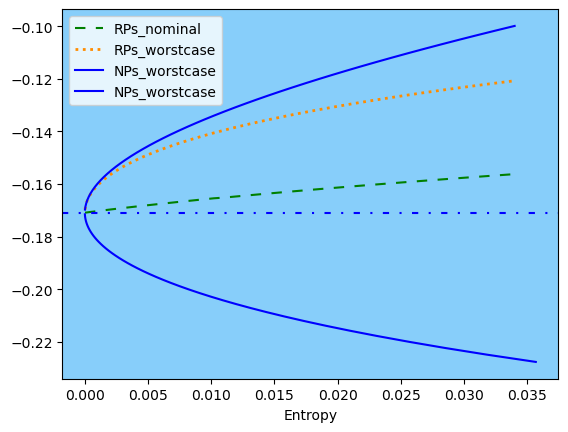

In [87]:
# No bounds no linear constraints just simple results
fig = plt.figure()
#fig.patch.set_facecolor('lightskyblue')
ax = plt.gca()
ax.set_facecolor('lightskyblue')
df_wc.plot(ax = ax, x='Entropy',y='RPs_nominal', linestyle=(0, (5, 5)), linewidth=1.5, color='green')
ax.axhline(y = performance_nominal, color = 'b', linestyle = (0, (3, 5, 1, 5)))
df_wc.plot(ax = ax, x='Entropy',y='RPs_worstcase', linestyle='dotted', linewidth=2, color='darkorange')
df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue')
neg_theta_df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue')
plt.show()

In [88]:
# Adding the sum constraint results in equi-weighted portfolios.

## Parameter Perturbations

In [89]:
I = np.eye(n)

results_rho_pf = []
results_rho_ent = []
for rho_ij in np.linspace(0.05, 0.45, 41):
    Sigma_change = np.full((n, n), rho_ij*sig_ii*sig_ii)
    
    # Set the diagonal elements to the diagonal value
    np.fill_diagonal(Sigma_change, sig_ii*sig_ii)
    
    a_cap = (1/gamma)* inv(Sigma_change) @ mu
    
    performance_pp = portfolio_performance(a_cap, mu, Sigma_change, gamma)
                    
    Rel_entropy_pp = (np.log(det(Sigma @ inv(Sigma_change) )) + np.trace(inv(Sigma) @ Sigma_change - I))/2
    results_rho_pf.append(performance_pp)
    results_rho_ent.append(Rel_entropy_pp)

In [90]:
results_kap_pf = []
results_kap_ent = []

for kappa in np.linspace(0.72, 1.32, 41):
    Sigma_change = kappa*Sigma
    
    a_cap = (1/gamma)* inv(Sigma_change) @ mu
        
    performance_pp = portfolio_performance(a_cap, mu, Sigma_change, gamma)
    Rel_entropy_pp = (np.log(det(Sigma @ inv(Sigma_change) )) + np.trace(inv(Sigma) @ Sigma_change - I))/2
    results_kap_pf.append(performance_pp)
    results_kap_ent.append(Rel_entropy_pp)

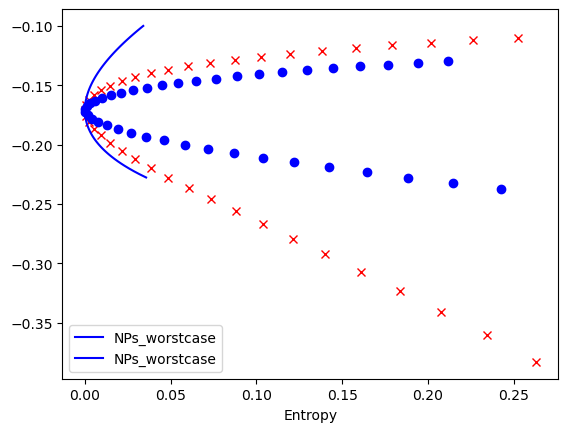

In [91]:
ax = plt.gca()
ax.plot(results_rho_ent, results_rho_pf, 'rx', linewidth=1)
ax.plot(results_kap_ent, results_kap_pf, 'bo', linewidth=1)
df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue')
neg_theta_df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue')
plt.show()